footprints:

in game- 0: <10m, 1: 10-25m, 2: 25-100m, 3: 100-1000m

for simplicity, now assume pokemons do not disappear from radar (i.e. 3 footprints represent 50-inf)

Also assume there are always 9 pokemons on display initially, and their initial locations are random in a 100*100 square

Detection: when a pokemon enters a 10m radius around the player, it is detected (tracking game success)

The game will report to the player the rough distance of each pokemon and their relative distance ranking

The goal of the tracking game is to find a particular pokemon

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from scipy.stats import gennorm
from scipy.stats import gamma
%matplotlib inline

In [2]:
def generate_initial_coordinates(side_length=2000, n_pokemon=9):
    pokemons = {}
    for i in range(n_pokemon):
        pokemons[i] = (random.uniform(-side_length/2, side_length/2), random.uniform(-side_length/2, side_length/2))
    return pokemons

In [3]:
pokemons = generate_initial_coordinates()
pokemons

{0: (772.4417316538036, -516.4096306027311),
 1: (-788.921673129346, 490.4611526343069),
 2: (-466.27199484309824, 32.828917480969494),
 3: (101.21036455077206, -789.4832201546528),
 4: (426.3376838658701, -722.9903998202446),
 5: (714.566544029479, 24.543122646979555),
 6: (-242.74096572189728, -158.6229873534295),
 7: (-473.1532828577567, 95.98403357080701),
 8: (-217.39814768356518, -487.2072089531363)}

Now we can visualise the relationship between player location, various detection radii and initial pokemon locations

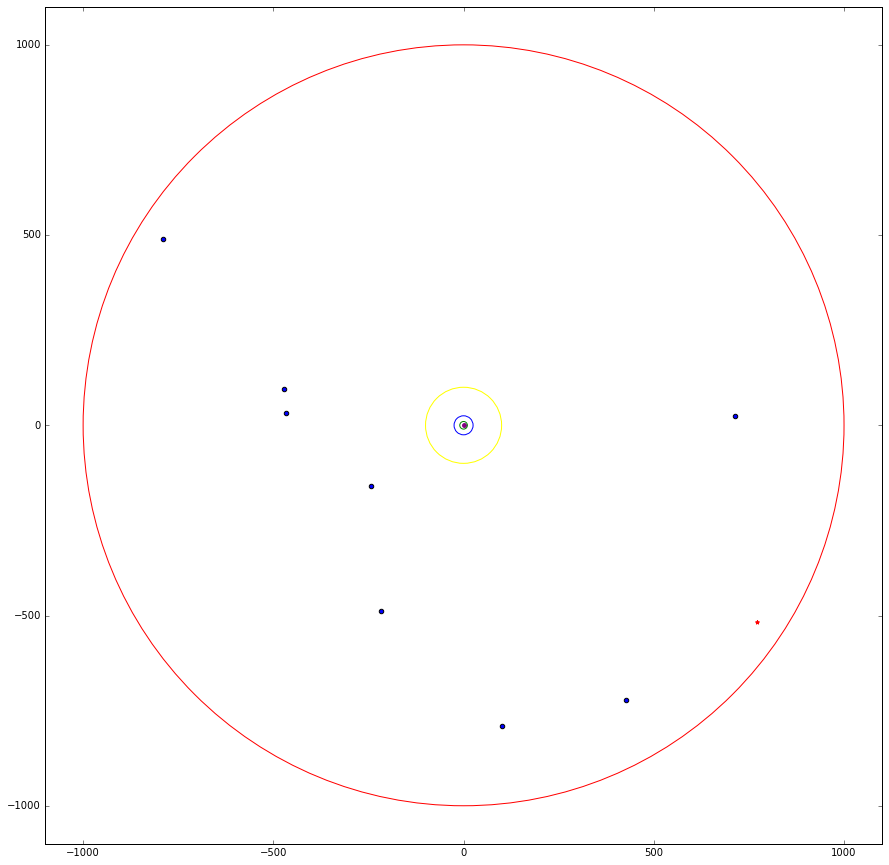

In [4]:
plt.figure(figsize=(15,15))
# non-target pokemons
plt.scatter([x for x, y in [coord for coord in pokemons.values()]][1:], 
            [y for x, y in [coord for coord in pokemons.values()]][1:])
# target pokemon
plt.scatter([x for x, y in [coord for coord in pokemons.values()]][0], 
            [y for x, y in [coord for coord in pokemons.values()]][0],
           marker="*", color='red', s=15)
plt.axes().set_aspect(1)
plt.axes().set_xlim((-1100, 1100))
plt.axes().set_ylim((-1100, 1100))
# player
plt.scatter(0, 0, color='purple', s=15)
# detection radii
dists = {10:'green', 25:'blue', 100:'yellow', 1000:'red'}
for r in dists:
    plt.axes().add_patch(plt.Circle((0,0), r, fill=False, color=dists[r]))
plt.show()

In [5]:
def distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

In [6]:
# this is not visible to players
def pokemon_distances(player_coord, pokemons):
    return {i: distance(player_coord, coord) for i, coord in pokemons.items()}

In [7]:
pokemon_distances((0, 0), pokemons)

{0: 929.16367523680992,
 1: 928.95077833897085,
 2: 467.42626263180222,
 3: 795.94427744551331,
 4: 839.33243647338679,
 5: 714.98790948903331,
 6: 289.9731514408283,
 7: 482.790807472133,
 8: 533.50990531774596}

In [8]:
def rank(input):
    output = [0] * len(input)
    for i, x in enumerate(sorted(range(len(input)), key=lambda y: input[y])):
        output[x] = i
    return output

In [9]:
# player will be able to see this
def pokemon_rankings(player_coord, pokemons):
    dists = pokemon_distances(player_coord, pokemons)
    rankings = {}
    for i, x in enumerate(sorted(range(len(dists)), key=lambda y: dists[y])):
        rankings[x] = i
    return rankings

In [10]:
pokemon_rankings((0, 0), pokemons)

{0: 8, 1: 7, 2: 1, 3: 5, 4: 6, 5: 4, 6: 0, 7: 2, 8: 3}

In [11]:
def plot_pokemon(player_coord, pokemons):
    plt.figure(figsize=(15,15))
    # non-target pokemons
    plt.scatter([x - player_coord[0] for x, y in [coord for coord in pokemons.values()]][1:], 
                [y - player_coord[1] for x, y in [coord for coord in pokemons.values()]][1:])
    # target pokemon
    plt.scatter([x - player_coord[0] for x, y in [coord for coord in pokemons.values()]][0], 
                [y - player_coord[1] for x, y in [coord for coord in pokemons.values()]][0],
               marker="*", color='red', s=15)
    plt.axes().set_aspect(1)
    plt.axes().set_xlim((-1100, 1100))
    plt.axes().set_ylim((-1100, 1100))
    # player
    plt.scatter(0, 0 , color='purple', s=15)
    # detection radii
    dists = {10:'green', 25:'blue', 100:'yellow', 1000:'red'}
    for r in dists:
        plt.axes().add_patch(plt.Circle((0,0), r, fill=False, color=dists[r]))
    plt.show()

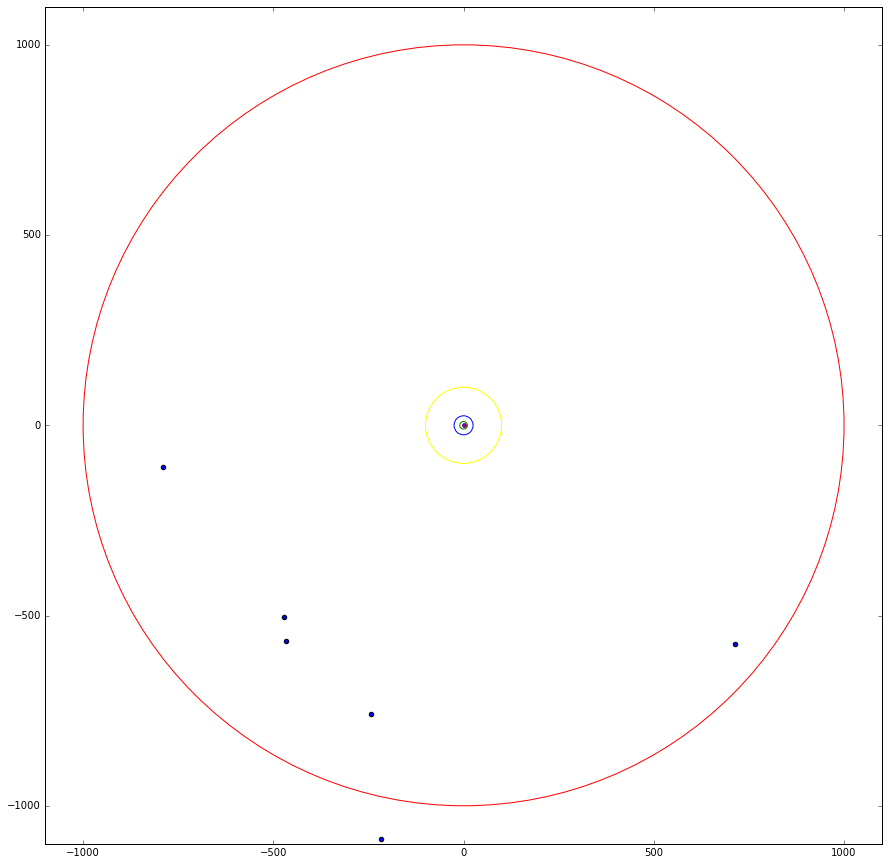

In [12]:
plot_pokemon((0, 600), pokemons)

In [13]:
def footprint(distance):
    if distance < 10:
        return 0
    elif distance < 25:
        return 1
    elif distance < 100:
        return 2
    elif distance < 1000:
        return 3
    else:
        return np.nan

def footprint_counts(player_coord, pokemons):
    dists = pokemon_distances(player_coord, pokemons)
    return {i: footprint(v) for i,v in dists.items()}

In [14]:
footprint_counts((0, 0), pokemons)

{0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3}

movesets:

move up/down/left/right x (default 5) m

rewards:

1. target estimated distance increased: moderate penalty
2. target estimated distance decreased: moderate reward
3. target ranking increased: slight reward
4. target ranking decreased: slight penalty
5. target within catch distance: huge reward (game won)
6. (optional) target lost (outside of detection range): large penalty

currently new pokemon spawns / pokemons outside of inital detection range are omitted

known information:

1. distance ranking and distance estimate for all pokemons within detection range
2. current player location relative to starting point
3. player moves so far (potentially equivalent to 2)

learning objective:

efficient algorithm to reach the target pokemon

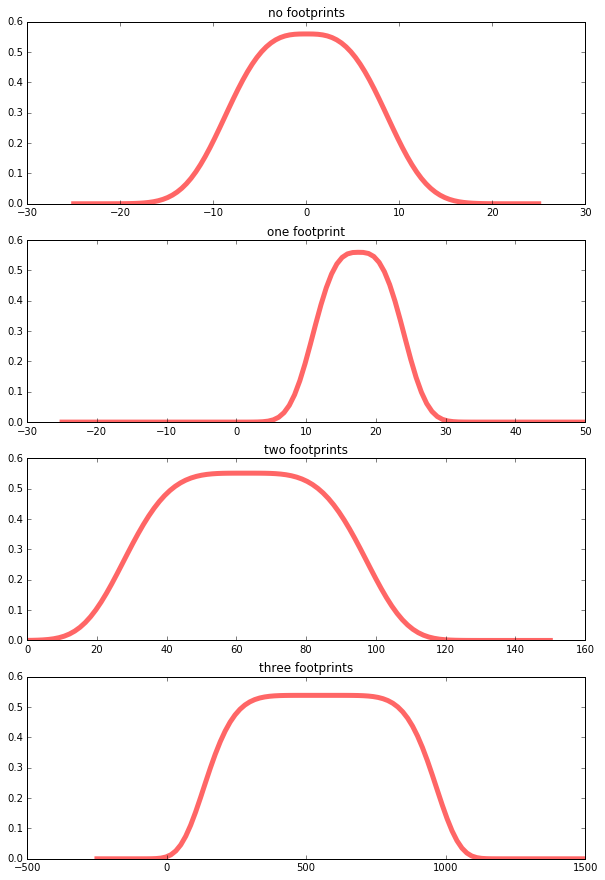

In [15]:
fig, ax = plt.subplots(4, 1)
fig.set_figwidth(10)
fig.set_figheight(15)

beta = 3
x = np.linspace(-25, 25, 100)
ax[0].plot(x, gennorm.pdf(x / 10, beta), 'r-', lw=5, alpha=0.6, label='gennorm pdf')
ax[0].set_title("no footprints")

beta0 = 3
x = np.linspace(-25, 50, 100)
ax[1].plot(x, gennorm.pdf((x - 17.5) / 7.5, beta0), 'r-', lw=5, alpha=0.6, label='gennorm pdf')
ax[1].set_title("one footprint")

beta1 = 4
# x = np.linspace(gennorm.ppf(0.01, beta), gennorm.ppf(0.99, beta), 100)
x = np.linspace(0, 150, 100)
ax[2].plot(x, gennorm.pdf((x - 62.5) / 37.5, beta1), 'r-', lw=5, alpha=0.6, label='gennorm pdf')
ax[2].set_title("two footprints")

beta2 = 6
x = np.linspace(-250, 1500, 100)
ax[3].plot(x, gennorm.pdf((x - 550) / 430, beta2), 'r-', lw=5, alpha=0.6, label='gennorm pdf')
ax[3].set_title("three footprints")

plt.show()

Assuming no knowledge of player movement history, the above graphs give us a rough probability distribution of actual distance of a pokemon given the estimated distance.

We may establish a relationship between player location plus n_footprints of a pokemon and the probable locations of the pokemon. Combine this with previous estimates of the location, we can improve our estimation step by step. This can be done with particle filter algorithm.

However, the footprints only offer us very limited information (especially because the "three footprints" range is significantly longer than the other two). We must be able to infer information from the pokemon distance rankings.

Suppose we have pokemon A and B. Let ">" denote "ranked before". If A>B, we know that pokemon A is closer to the player than pokemon B. Suppose after some player movement, A and B swapped rankings. Now B>A and B is closer to the player than A. We may infer that:

1. at the moment of swap, A and B are roughly the same distance from the player
2. (following 1) in the joint A and B distribution, values where abs(distance(A) - distance(B)) is small should be more probable than values where the difference is large

Now consider pokemon C and D. Both have three footprints but C>D. It is reasonable to believe that C is more likely to be in the inner range of the three-footprint radius and D is more likely to be in the outer range. If there are multiple pokemons in the three-footprint range, we may use a skewed probability distribution to estimate the locations of the highest and lowest ranking pokemons.

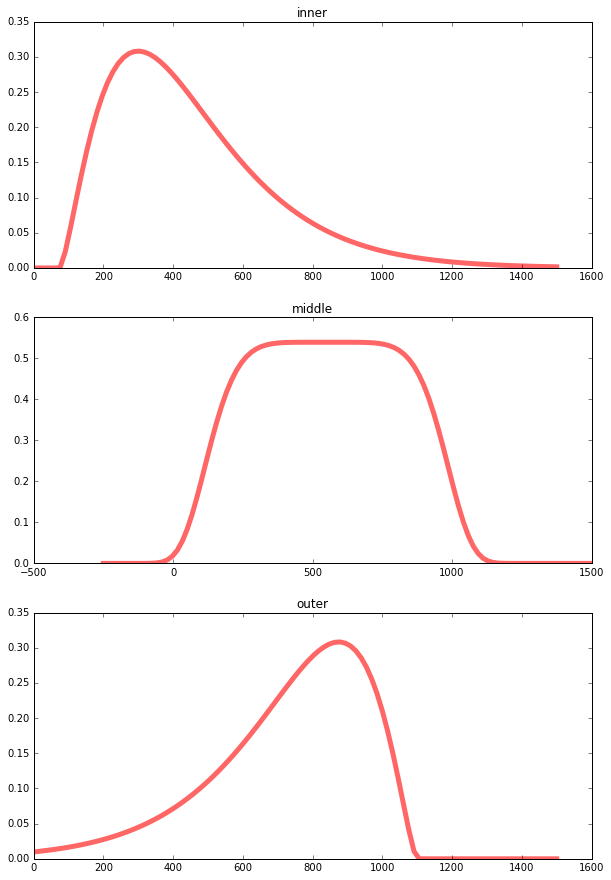

In [16]:
fig, ax = plt.subplots(3, 1)
fig.set_figwidth(10)
fig.set_figheight(15)

a = 2.5
x = np.linspace(0, 1500, 100)
ax[0].plot(x, gamma.pdf((x - 75) / (450/3), a), 'r-', lw=5, alpha=0.6, label='gamma pdf')
ax[0].set_title("inner")

beta2 = 6
x = np.linspace(-250, 1500, 100)
ax[1].plot(x, gennorm.pdf((x - 550) / 450, beta2), 'r-', lw=5, alpha=0.6, label='gennorm pdf')
ax[1].set_title("middle")

a0 = 2.5
x = np.linspace(0, 1500, 100)
ax[2].plot(x, gamma.pdf((-x + 1100) / (450/3), a0), 'r-', lw=5, alpha=0.6, label='gamma pdf')
ax[2].set_title("outer")

plt.show()

Now for pokemons with three footprints, we apply these skewed distributions to estimate their distance if they are ranked first or last (or first k / last k, k adjustable).

The other question remains: how do we exploit the information from rank changes?

Suppose we have m particles (estimated locations) for pokemon A and B respectively. The total number of combinations is m\*m. For each of the combinations, we calculate the distance difference of A and B. The combinations we select from this population should follow a distribution that is highest at zero and decays as the variable increases.

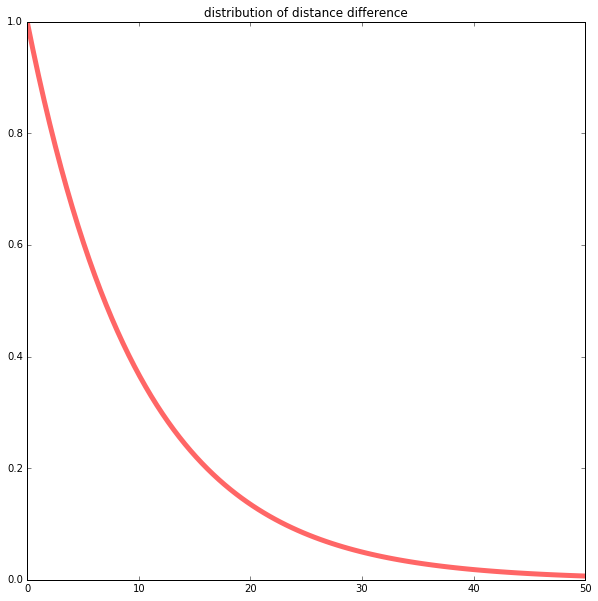

In [4]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(10)

a = 1
x = np.linspace(0, 50, 100)
ax.plot(x, gamma.pdf(x / 10, a), 'r-', lw=5, alpha=0.6, label='gennorm pdf')
ax.set_title("distribution of distance difference")

Also we might have to consider situations where a pokemon pops in / disappears from radar. This means they are almost certainly at that point on the edge of the detection radius. Their distance should follow a more skewed distribution.

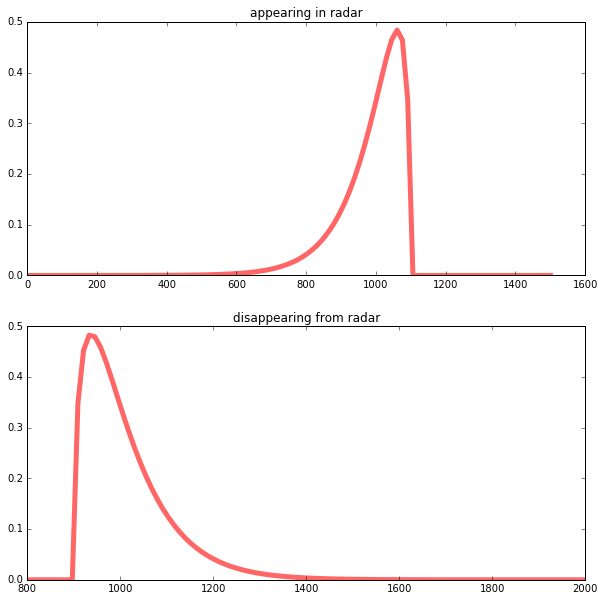

In [18]:
fig, ax = plt.subplots(2, 1)
fig.set_figwidth(10)
fig.set_figheight(10)

a0 = 1.5
x = np.linspace(0, 1500, 100)
ax[0].plot(x, gamma.pdf((-x + 1100) / (450/6), a0), 'r-', lw=5, alpha=0.6, label='gamma pdf')
ax[0].set_title("appearing in radar")

a = 1.5
x = np.linspace(800, 2000, 100)
ax[1].plot(x, gamma.pdf((x - 900) / (450/6), a), 'r-', lw=5, alpha=0.6, label='gamma pdf')
ax[1].set_title("disappearing from radar")

plt.show()

Situations where we need to re-estimate the distance:

1. initially, when we first receive the footprint counts and rankings
2. when the footprint count of a pokemon changes
3. when a swap in ranking happens (with multiple swaps at the same time, treat it as pairwise swaps)
4. when the highest / lowest ranking pokemon changes
5. when a pokemon enters / exits radar radius

In order to help learning an optimal policy, we need a reward / fitness function to estimate how close we are to locating / reaching the target pokemon.

base_fitness = weighed average distance from estimated locations of the target pokemon

small bonus rewards could be given to triggering new weight-updating events as that offers us more information

reward of a move = fitness change + bonus rewards for extra information

A "step" or "move" can be restricted to traveling up/down/left/right 5m for simplicity.

We can know the base fitness change of a step before taking the move, but we do not know the bonus information until after we take the move.

In [19]:
def random_particle_generation(side_length=2000, n=1000):
    particles = [0] * n
    for i in range(n):
        particles[i] = (random.uniform(-side_length/2, side_length/2), random.uniform(-side_length/2, side_length/2))
    return particles

def plot_particles(player_coord, particles):
    plt.figure(figsize=(15,15))
    plt.scatter([p[0] - player_coord[0] for p in particles], 
                [p[1] - player_coord[1] for p in particles])
    plt.axes().set_aspect(1)
    plt.axes().set_xlim((-1100, 1100))
    plt.axes().set_ylim((-1100, 1100))
    # player
    plt.scatter(0, 0 , color='purple', s=15)
    # detection radii
    dists = {10:'green', 25:'blue', 100:'yellow', 1000:'red'}
    for r in dists:
        plt.axes().add_patch(plt.Circle((0,0), r, fill=False, color=dists[r]))
    plt.show()

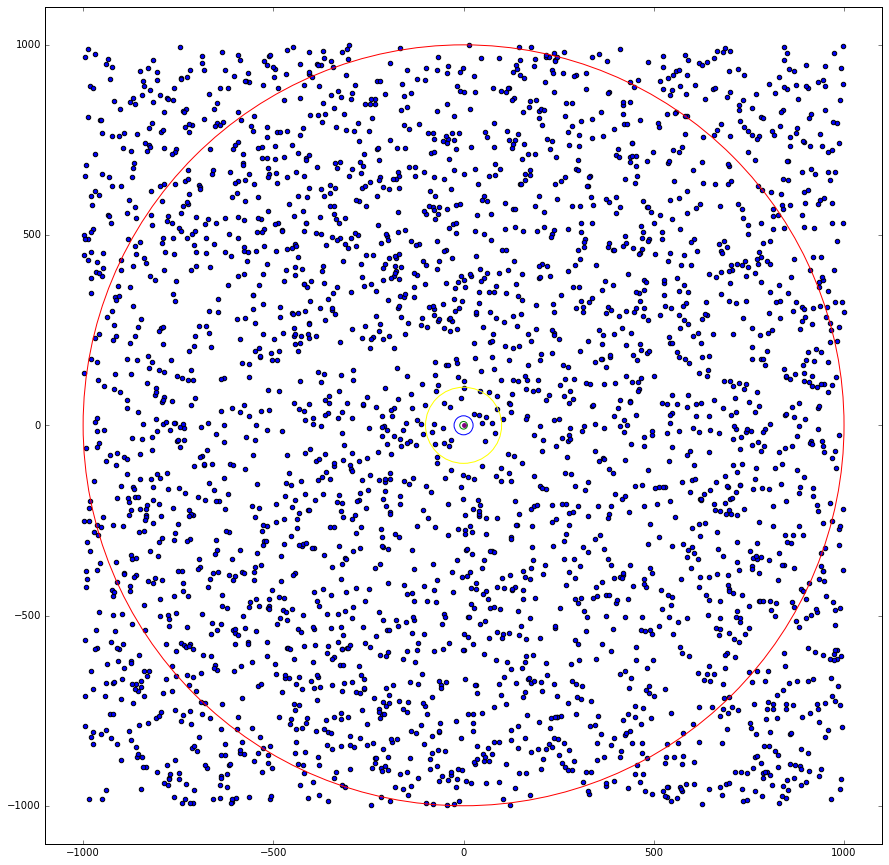

In [41]:
particles = random_particle_generation(n=3000)
plot_particles((0, 0), particles)

(array([  70.,  160.,  259.,  329.,  426.,  524.,  593.,  391.,  207.,   41.]),
 array([   39.42306954,   176.57992632,   313.7367831 ,   450.89363987,
          588.05049665,   725.20735343,   862.36421021,   999.52106698,
         1136.67792376,  1273.83478054,  1410.99163732]),
 <a list of 10 Patch objects>)

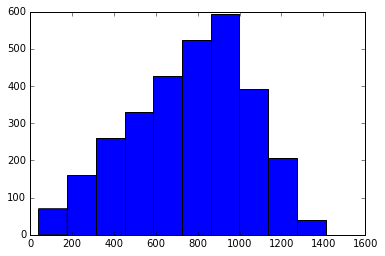

In [42]:
# sample according to distance distribution
particle_dists = list(map(lambda c: distance(c, (0, 0)), particles))
plt.hist(particle_dists)

(array([  428.,    82.,    98.,    80.,    83.,    83.,   130.,   169.,
          218.,  1629.]),
 array([  2.66384518e-22,   5.38956107e-02,   1.07791221e-01,
          1.61686832e-01,   2.15582443e-01,   2.69478053e-01,
          3.23373664e-01,   3.77269275e-01,   4.31164885e-01,
          4.85060496e-01,   5.38956107e-01]),
 <a list of 10 Patch objects>)

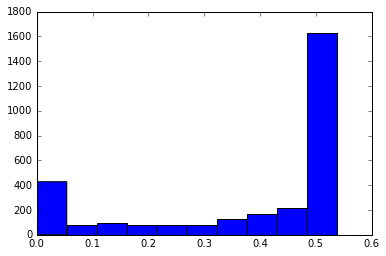

In [43]:
def three_middle(x):
    beta = 6
    return gennorm.pdf((x - 550) / 450, beta)
particle_probs = list(map(three_middle, particle_dists))
def two_fp(x):
    beta = 4
    return gennorm.pdf((x - 62.5) / 37.5, beta)
particle_probs = list(map(three_middle, particle_dists))
plt.hist(particle_probs)

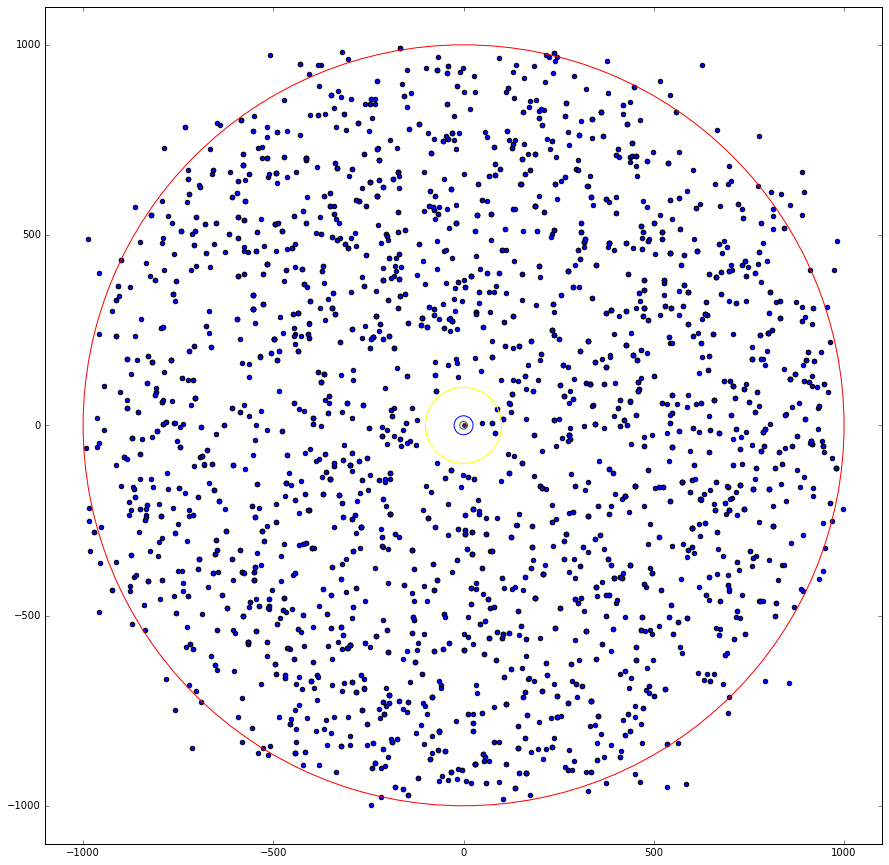

In [44]:
new_particles = [particles[np.random.choice(range(len(particles)), p=particle_probs / sum(particle_probs))] 
                 for i in range(len(particles))]
plot_particles((0, 0), new_particles)

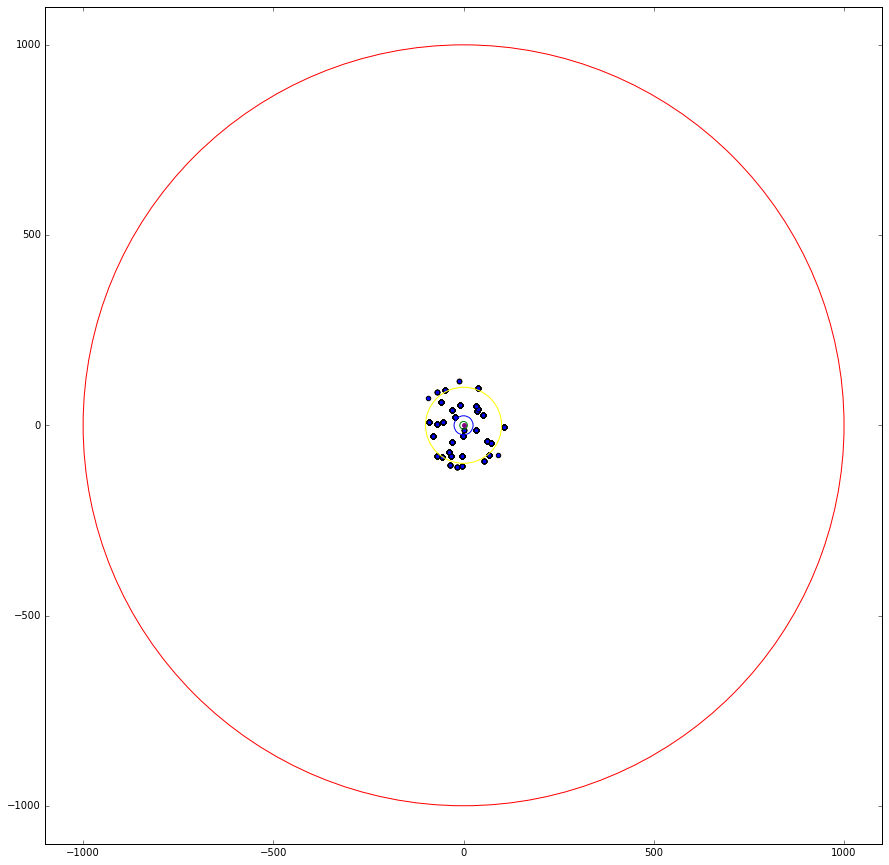

In [45]:
# now suppose player moved to (200, 200) and the footprint count reduced to 2
player_coord = (200, 200)
particle_dists = list(map(lambda c: distance(c, player_coord), particles))
particle_probs = list(map(two_fp, particle_dists))
new_particles = [particles[np.random.choice(range(len(particles)), p=particle_probs / sum(particle_probs))] 
                 for i in range(len(particles))]
plot_particles(player_coord, new_particles)

**Particle Filter Algorithm**

1. (sim) initialise pokemon positions
2. get initial pokemon distance level and rankings
3. create random particles for each pokemon on radar
4. assign selection probabilities to each particle based on the respective distance levels and rankings of that pokemon
5. resample the particle population of each pokemon based on the selection probabilities obtained in step 4
6. calculate the weighed average location of target pokemon
7. start moving in the direction of the weighed average location of target pokemon
8. listen for distance level or ranking change events. On event, halt moving and:
    1. re-calculate particle selection probabilities of affected pokemon(s)
    2. resample the particle population of affected pokemon(s)
    3. re-calculate weighed average location of target pokemon
    4. start moving in the direction obtained in the previous step and resume listening for events
9. program terminates when the target pokemon is within zero-footprint distance

** To be continued in particle_filter_algorithm**